In [43]:
!pip install gradio
!pip install openai==0.28

In [44]:
import os
import openai
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from transformers import AutoImageProcessor, Dinov2ForImageClassification
import torch

# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

import torch
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
# 모델 삭제
del model

In [75]:
# GPU 사용 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 이미지 전처리기 로드
#image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small-imagenet1k-1-layer")

image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base-imagenet1k-1-layer")
# image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-large-imagenet1k-1-layer")
# image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-giant-imagenet1k-1-layer")

# DINOv2 사전 학습된 모델 로드
# model = Dinov2ForImageClassification.from_pretrained("facebook/dinov2-small-imagenet1k-1-layer")

model = Dinov2ForImageClassification.from_pretrained("facebook/dinov2-base-imagenet1k-1-layer")
# model = Dinov2ForImageClassification.from_pretrained("facebook/dinov2-large-imagenet1k-1-layer")
# model = Dinov2ForImageClassification.from_pretrained("facebook/dinov2-giant-imagenet1k-1-layer")

model.to(device)

Dinov2ForImageClassification(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
       

In [76]:
# 전처리 정의 (이미지 크기 조정 및 텐서로 변환)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # DINOv2 모델에 맞는 입력 크기
    transforms.ToTensor(),
])


In [77]:
# 데이터셋 로드
train_dataset = ImageFolder(root='/content/drive/My Drive/projects/data/train', transform=transform)
test_dataset = ImageFolder(root='/content/drive/My Drive/projects/data/test', transform=transform)

# DataLoader 설정
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [78]:
# 분류 레이어 추가 및 교체 (원하는 클래스 수에 맞게 변경)
num_classes = 3  # 원하는 클래스 수 (예: 3개 분류)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

# 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Epoch 1/40
--------------------
Epoch 1 Loss: 1.9131, Accuracy: 0.3067

최고 정확도 갱신: 0.3067 - 모델 가중치 저장됨

Epoch 2/40
--------------------
Epoch 2 Loss: 1.1171, Accuracy: 0.4067

최고 정확도 갱신: 0.4067 - 모델 가중치 저장됨

Epoch 3/40
--------------------
Epoch 3 Loss: 1.1693, Accuracy: 0.3133

Epoch 4/40
--------------------
Epoch 4 Loss: 1.1139, Accuracy: 0.3333

Epoch 5/40
--------------------
Epoch 5 Loss: 1.1158, Accuracy: 0.2800

Epoch 6/40
--------------------
Epoch 6 Loss: 1.1015, Accuracy: 0.3867

Epoch 7/40
--------------------
Epoch 7 Loss: 1.0245, Accuracy: 0.4933

최고 정확도 갱신: 0.4933 - 모델 가중치 저장됨

Epoch 8/40
--------------------
Epoch 8 Loss: 1.0516, Accuracy: 0.4267

Epoch 9/40
--------------------
Epoch 9 Loss: 1.0119, Accuracy: 0.5067

최고 정확도 갱신: 0.5067 - 모델 가중치 저장됨

Epoch 10/40
--------------------
Epoch 10 Loss: 0.9387, Accuracy: 0.5067

Epoch 11/40
--------------------
Epoch 11 Loss: 0.9571, Accuracy: 0.5267

최고 정확도 갱신: 0.5267 - 모델 가중치 저장됨

Epoch 12/40
--------------------
Epoch 12 Lo

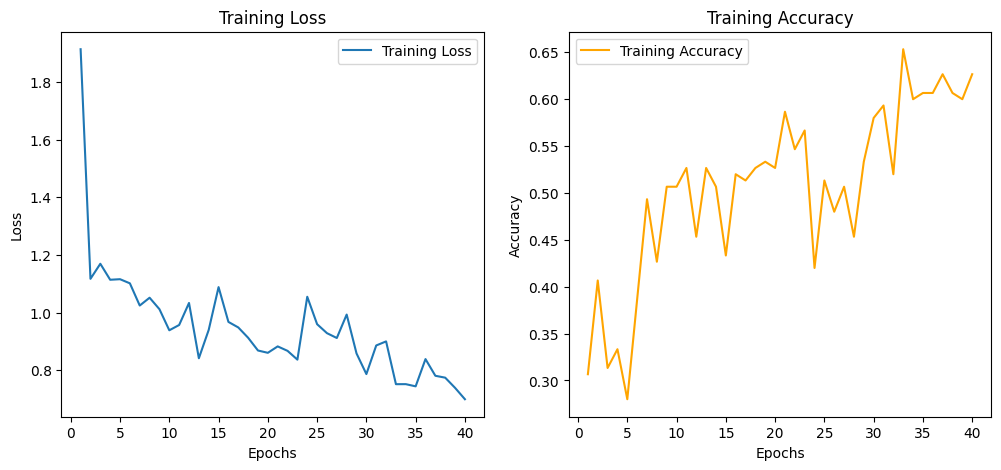

In [79]:
# 모델을 GPU로 이동
model.to(device)

# Fine-tuning (모델 학습)
model.train()
num_epochs = 40  # 에포크 수 설정
best_accuracy = 0.0  # 최고 정확도를 저장할 변수

# 손실과 정확도를 저장할 리스트
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0  # 에포크당 누적 손실을 저장
    correct_predictions = 0  # 정확한 예측을 저장
    total_predictions = 0  # 전체 예측 수를 저장

    print(f'Epoch {epoch+1}/{num_epochs}')  # 에포크 시작 출력
    print('-' * 20)

    for i, batch in enumerate(train_dataloader, 0):
        inputs = batch[0].to(device)  # 이미지 데이터
        labels = batch[1].to(device)  # 레이블 데이터

        optimizer.zero_grad()  # 이전 그라디언트 초기화
        outputs = model(inputs)  # 모델에 데이터 입력

        logits = outputs.logits  # 로짓 값 추출
        loss = criterion(logits, labels)  # 손실 계산

        loss.backward()  # 역전파 수행
        optimizer.step()  # 가중치 업데이트

        running_loss += loss.item()  # 손실을 누적

        # 정확도 계산
        _, predicted = torch.max(logits, 1)  # 가장 높은 확률을 갖는 클래스 예측
        correct_predictions += (predicted == labels).sum().item()  # 맞춘 예측 수
        total_predictions += labels.size(0)  # 전체 예측 수

    # 에포크당 평균 손실과 정확도 계산
    epoch_loss = running_loss / len(train_dataloader)
    epoch_accuracy = correct_predictions / total_predictions

    train_losses.append(epoch_loss)  # 손실 저장
    train_accuracies.append(epoch_accuracy)  # 정확도 저장

    print(f'Epoch {epoch+1} Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}\n')

    # 최고 정확도를 기록할 때마다 모델 가중치 저장
    if epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
        torch.save(model.state_dict(), '/content/drive/My Drive/projects/finetuned_dino.pth')  # 모델 가중치 저장
        print(f'최고 정확도 갱신: {best_accuracy:.4f} - 모델 가중치 저장됨\n')

# 학습 완료 후 손실과 정확도를 그래프로 출력
plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [9]:
# 모델 평가
model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        inputs = batch[0].to(device)  # 이미지 데이터
        labels = batch[1].to(device)  # 레이블 데이터

        # 모델에 입력 데이터를 전달하여 예측
        outputs = model(inputs)

        # 로짓(logits)을 가져와서 최대값을 찾음 (클래스 예측)
        _, preds = torch.max(outputs.logits, 1)

        # 정확도 계산
        corrects = torch.sum(preds == labels).item()
        print(f'Batch Accuracy: {corrects / len(labels) * 100:.2f}%')

Batch Accuracy: 100.00%
Batch Accuracy: 25.00%
Batch Accuracy: 0.00%
Batch Accuracy: 50.00%


In [10]:
# 모델 평가
model.eval()

# 단일 이미지를 입력하는 경우 (예: test_dataloader에서 첫 번째 이미지 사용)
with torch.no_grad():
    # 배치에서 첫 번째 이미지를 선택
    for batch in test_dataloader:
        inputs = batch[0][0].unsqueeze(0).to(device)  # 첫 번째 이미지를 선택하고 배치 차원 추가
        labels = batch[1][0].unsqueeze(0).to(device)  # 첫 번째 레이블 선택
        break

    # 모델에 입력 데이터를 전달하여 예측
    outputs = model(inputs)
    logits = outputs.logits
    print(logits)

    # 예측한 라벨 (가장 큰 값을 가지는 클래스)
    _, preds = torch.max(logits, 1)

    # 예측한 라벨과 실제 라벨 출력
    print(f'Predicted Label: {preds.item()}')  # 모델이 예측한 라벨
    print(f'Actual Label: {labels.item()}')  # 실제 라벨


tensor([[ 0.7602,  0.3920, -1.5328]], device='cuda:0')
Predicted Label: 0
Actual Label: 0


In [81]:
# 저장된 가중치 확인
state_dict = torch.load('/content/drive/My Drive/projects/finetuned_dino.pth')
print(state_dict['classifier.weight'].shape)  # 출력층 가중치 크기 확인

<ipython-input-81-483edbafd32b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/drive/My Drive/projects/finetuned_dino.pth')


torch.Size([3, 1536])


In [82]:
import gradio as gr
from transformers import AutoImageProcessor, Dinov2ForImageClassification
from PIL import Image
import torch

# GPU 사용 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 이미지 전처리기 로드 (사전 학습된 모델과 동일한 processor 사용)
image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base-imagenet1k-1-layer")

# DINOv2 모델 구조 로드 (사전 학습된 모델 구조)
model = Dinov2ForImageClassification.from_pretrained("facebook/dinov2-base-imagenet1k-1-layer")

# 출력층을 3개의 클래스로 수정 (모델 헤드 수정)
model.classifier = nn.Linear(in_features=model.classifier.in_features, out_features=3)

# 저장된 모델 가중치 로드
model.load_state_dict(torch.load('/content/drive/My Drive/projects/finetuned_dino.pth'))

# 모델을 GPU로 이동
model.to(device)
model.eval()

# 파인튜닝한 3개의 클래스 이름 설정
class_names = ['class_1', 'class_2', 'class_3']



# 문장 생성 함수 정의
# OpenAI API 키 설정
openai.api_key = ''

import openai

def generate_forehead_analysis(class_input):
    """
    ChatGPT API를 활용하여 이마 주름 상태를 분석하는 함수.

    Args:
        class_input (str): 'class_1', 'class_2', 'class_3' 중 하나의 라벨을 입력 받음

    Returns:
        str: ChatGPT로부터 받은 이마 상태에 대한 분석 결과
    """

    if class_input == "class_2":
        class_description = "이마에 적당한 양의 주름이 있고 약간의 노화 징후가 보이는 상태입니다."
    elif class_input == "class_3":
        class_description = "이마에 많은 주름과 눈에 띄는 노화 징후가 보이는 상태입니다."
    else:
        class_description = "이마에 주름이 거의 없고 매우 부드러운 상태입니다."

    # ChatGPT API 프롬프트 생성
    prompt = f"피부 전문가로서 사용자의 이마 상태를 다음 설명을 바탕으로 분석해주세요: {class_description}. 첫 번째 문장은  '{class_description}'로 시작하고, 그 뒤에 간단한 피부 상태 분석과 개선을 위한 팁을 3줄 이내로 제공해주세요. 한국어로 응답해주세요."

    # ChatGPT API 호출
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "당신은 피부 관리 전문가입니다."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=200,  # 더 긴 답변을 위해 토큰 수를 증가
        stop=["\n"]  # 문장이 길어지는 것을 방지
    )

    # API 응답에서 텍스트 추출
    full_response = response['choices'][0]['message']['content']

    # 문장을 기준으로 텍스트를 분할
    sentences = full_response.split('.')

    # 마지막 문장이 중간에 끊겼는지 확인하고 제거
    if sentences[-1] != "" and sentences[-1][-1] != ".":
        sentences = sentences[:-1]  # 마지막 문장이 불완전하면 제거

    # 문장들을 다시 합쳐서 최종 결과 반환
    result = '. '.join(sentences).strip() + '.'

    return result



# 예측 함수 정의
def predict(image):
    try:
        # 입력 이미지가 None인 경우 처리
        if image is None:
            print("No image provided")
            return "No image provided"

        print("1. 이미지 전달됨")

        # 이미지를 모델에 맞게 전처리
        try:
            image = transform(image).unsqueeze(0).to(device)  # 전처리 후 차원 추가 및 장치로 이동
            print(f"3. 전처리 완료: 이미지 shape - {image.shape}")  # 전처리 후 크기 확인
        except Exception as e:
            print(f"Error during image processing: {e}")
            return f"Error during image processing: {e}"

        # 모델에 이미지 입력
        try:
            with torch.no_grad():
                outputs = model(image)  # inputs 대신 전처리된 image 사용
            print("4. 모델 예측 완료")
        except Exception as e:
            print(f"Error during model prediction: {e}")
            return f"Error during model prediction: {e}"

        # 클래스 예측
        try:
            logits = outputs.logits if hasattr(outputs, "logits") else outputs  # logits가 outputs에 있으면 사용
            print(f"Logits shape: {logits.shape}")  # logits 크기 확인
            predicted_class_idx = logits.argmax(-1).item()
            print(f"Predicted class index: {predicted_class_idx}")

        except Exception as e:
            print(f"Error during logits processing: {e}")
            return f"Error during logits processing: {e}"

        # 예측된 클래스 이름을 통해 문구 생성
        result = generate_forehead_analysis(class_names[predicted_class_idx])
        return result

    except Exception as e:
        print(f"Error during prediction: {e}")
        return f"Error during prediction: {str(e)}"

        # 예측된 클래스 이름을 통해 문구 생성
        result = generate_forehead_analysis(class_names[predicted_class_idx])
        return result

    except Exception as e:
        print(f"Error during prediction: {e}")
        return f"Error during prediction: {str(e)}"

# Gradio 인터페이스 정의
gr.Interface(
    fn=predict,  # 예측 함수를 연결
    inputs=gr.Image(type="pil"),  # 이미지를 입력받음
    outputs="text",  # 예측 결과는 텍스트로 출력
    title="LumiCare"
).launch()


<ipython-input-82-45d6f0a965fa>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/My Drive/projects/finetuned_dino.pth'))


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://996101aa3683cced3b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
